<a href="https://colab.research.google.com/github/sw2703/neural_style_transfer/blob/master/Simplified_neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import scipy.misc
import tensorflow as tf

# Helper functions for images


In [ ]:
def tensor_to_image(tensor):
  """
  Note: despite its name, the input does not have to be a tensor. It can be a 
  numpy array as well.
  """
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

90112/83281 [================================] - 0s 0us/step


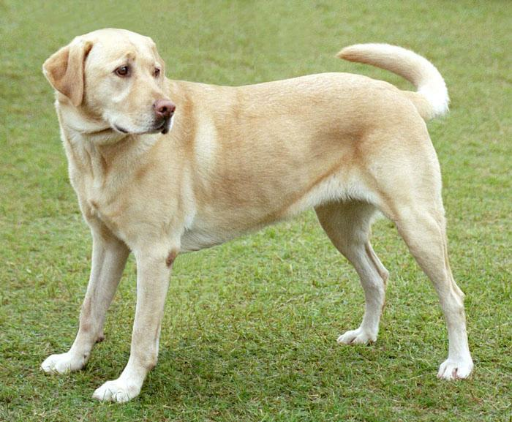

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
content_image = load_img(content_path)
tensor_to_image(content_image)

196608/195196 [==============================] - 0s 0us/step


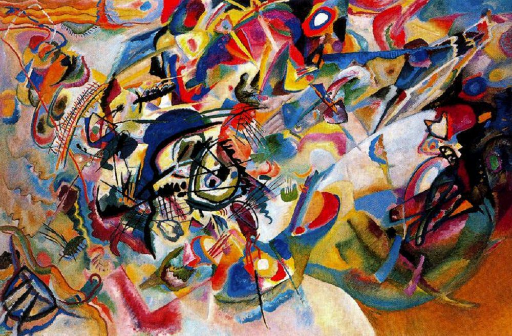

In [ ]:
# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
style_image = load_img(style_path)
tensor_to_image(style_image)

# Gram matrix

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)  

# Custom Model instance to get middle layers of VGG19
A common hurdle of neural style transfer is how to get the middle layers of a pretrained model, such as VGG19. There's no such method in the tf.keras.applications.VGG19 class itself. You have to create your own Model instance as follows.

In [ ]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False)
  model = tf.keras.Model(inputs=vgg.input, outputs=[vgg.get_layer(x).output for x in layer_names])
  return model

# Wrapper Model instance for VGG19
This is perhaps the most confusing part of the official TensorFlow tutorial. You might ask, since we already have the vgg_layers function above, why do we still need this StyleContentModel?

The answer is, vgg_layers above deals with the model **output**, i.e. getting the activation values of the middle layers of VGG19. This StyleContentModel deals with the model **input**, i.e. multiplying it by 255 and running it through tf.keras.applications.vgg19.preprocess_input. That's all -- nothing mysterious.

In other words, even if you're using VGG19 for other purposes, say distinguishing between cats and dogs, and your input pictures are in the same format as these two pictures here (values between 0 and 1), you still need to multiply your inputs by 255 and run it through tf.keras.applications.vgg19. You don't have to create a custom Model class for it, but you can.

In our case, since we have 4 calls of VGG19 -- getting style layers for the style and generated images, and getting the content layer for the content and generated images -- it's much more convenient to create a custom class than to write these lines 4 times.


In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, output_layers):
    super().__init__()
    self.vgg = vgg_layers(output_layers)

  def call(self, inputs):
    inputs = inputs*255.0
    processed_inputs = tf.keras.applications.vgg19.preprocess_input(inputs)
    activations = self.vgg(processed_inputs)
    return activations

# Loss function

In [ ]:
def style_content_loss(style_outputs, content_outputs):
    style_grams = map(gram_matrix, style_outputs)
    style_loss = tf.add_n([tf.reduce_mean((x-y)**2) 
                           for x, y in zip(style_grams, style_targets_grams)])

    content_loss = tf.reduce_mean((content_outputs-content_targets)**2)
    loss = style_loss * style_weight + content_loss * content_weight
    return loss    

# Running gradient descent
I guess the only confusing thing in this part is the @tf.function() decoration. Firstly, the decorator syntax -- 
```
def do_twice(func):
    def wrapper_do_twice():
        func()
        func()
    return wrapper_do_twice

@do_twice
def say_whee():
    print("Whee!")    
```
is just equivalent to 
```
def do_twice(func):
    def wrapper_do_twice():
        func()
        func()
    return wrapper_do_twic

def say_whee_core():
    print("Whee!")

def say_whee():
    do_twice(say_whee_core)
```
And secondly, tf.function() is a built-in function of tensorflow that creates Python-independent dataflow graphs that run faster. 

You can try commenting out the @tf.function() line. The code still runs, but takes longer.

References: 

https://realpython.com/primer-on-python-decorators/

https://www.tensorflow.org/guide/function



80142336/80134624 [==============================] - 0s 0us/step


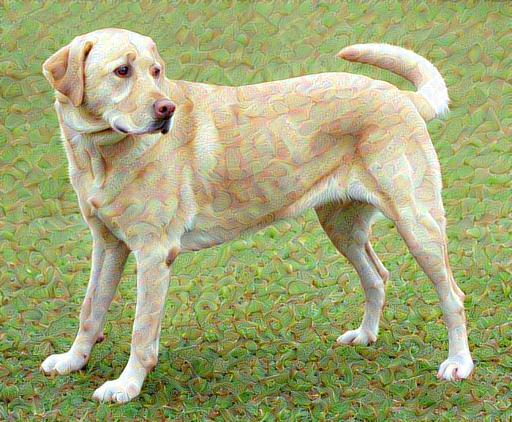

In [ ]:
image = tf.Variable(content_image)
style_extractor = StyleContentModel([
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'])
content_extractor = StyleContentModel(['block5_conv2'])
style_targets = style_extractor(style_image)
style_targets_grams = [gram_matrix(x) for x in style_targets]
content_targets = content_extractor(content_image)

style_weight = 2e-3
content_weight = 1e4

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    style_outputs = style_extractor(image)
    content_outputs = content_extractor(image)
    loss = style_content_loss(style_outputs, content_outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(tf.clip_by_value(image, 0, 1))

train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)


In [ ]:
%%time
for i in range(1000):
  train_step(image)   

CPU times: user 1min 13s, sys: 1min 6s, total: 2min 19s
Wall time: 2min 20s


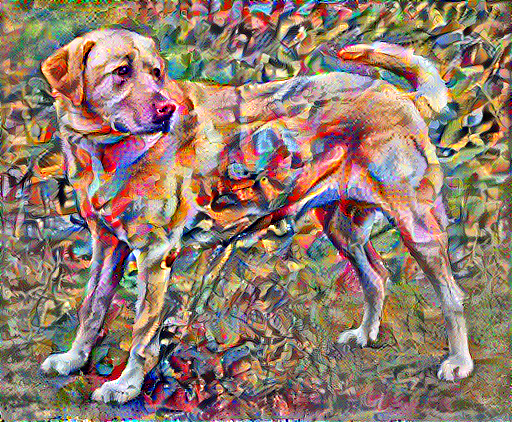

In [ ]:
tensor_to_image(image)      

# End
The last two sections in the Tensorflow official tutorial titled "Total variation loss" and "Re-run the optimization" are quite intuitive, and are not included here.